In [ ]:

# # Comparative Saccade Detection Pipeline
# This notebook integrates the unified `create_saccade_events` function into the existing BlockSync pipeline,
# then produces multi-animal polar histogram plots comparing:
# 1. **XY-based saccade detection** (pixel-space speed threshold)
# 2. **Angular-based saccade detection** (degree-space speed threshold)
#
# Modify file paths and parameters as needed for your local setup.


In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from scipy import signal
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
import tqdm


In [ ]:
# ## 1. Unified `create_saccade_events` Function
# The function below computes both pixel-space and angular-space speeds, then thresholds either
# `speed_r` ("xy" mode) or `angular_speed_r` ("angular" mode) to detect saccade onsets/offsets.
# It returns:
#  - `df_out` (the input `eye_data_df` with extra speed columns)
#  - `saccade_events_df` (one row per sub-saccade, with both pixel-based and angular-based metrics).


In [2]:
def create_saccade_events(
    eye_data_df: pd.DataFrame,
    detection_mode: str = 'xy',
    speed_threshold: float = 1.0,
    directional_delta_threshold_deg: float = 25.0,
    magnitude_calib: float = 1.0,
    speed_profile: bool = True,
    min_subsaccade_samples: int = 2,
    min_net_disp: float = 0.5
) -> (pd.DataFrame, pd.DataFrame):
    """
    Unified saccade detection:
      - 'xy': pixel-space speed (speed_r)
      - 'angular': angular-space speed (angular_speed_r)

    Returns:
      df_out: copy of eye_data_df with extra columns:
        ['speed_x','speed_y','speed_r',
         'angular_speed_phi','angular_speed_theta','angular_speed_r']
      saccade_events_df: one row per (sub-)saccade, with columns:
        ['saccade_start_ind','saccade_end_ind',
         'saccade_start_timestamp','saccade_end_timestamp',
         'saccade_on_ms','saccade_off_ms',
         'length',
         'magnitude_raw_pixel','magnitude_pixel','xy_angle_deg',
         'initial_x','initial_y','end_x','end_y',
         'magnitude_raw_angular','overall_angle_deg',
         'phi_init_pos','theta_init_pos','phi_end_pos','theta_end_pos',
         'net_angular_disp',
         'speed_profile_pixel','speed_profile_angular' (if requested) ]
    """

    # 1. Copy input to avoid modifying original
    df = eye_data_df.copy().reset_index(drop=True)

    # 2. Compute pixel-space speeds
    df['speed_x'] = df['center_x'].diff()
    df['speed_y'] = df['center_y'].diff()
    df['speed_r'] = np.sqrt(df['speed_x']**2 + df['speed_y']**2)

    # 3. Compute angular-space speeds (requires 'k_phi','k_theta')
    df['angular_speed_phi'] = df['k_phi'].diff()
    df['angular_speed_theta'] = df['k_theta'].diff()
    df['angular_speed_r'] = np.sqrt(df['angular_speed_phi']**2 + df['angular_speed_theta']**2)

    # 4. Choose which speed to threshold
    if detection_mode.lower() not in ('xy', 'angular'):
        raise ValueError("detection_mode must be 'xy' or 'angular'")
    if detection_mode.lower() == 'xy':
        df['is_saccade_flag'] = df['speed_r'] > speed_threshold
    else:
        df['is_saccade_flag'] = df['angular_speed_r'] > speed_threshold

    # 5. Find rising/falling edges of the boolean mask
    sacc_on_off = df['is_saccade_flag'].astype(int) - df['is_saccade_flag'].shift(1, fill_value=0).astype(int)
    on_inds  = np.where(sacc_on_off == 1)[0]
    off_inds = np.where(sacc_on_off == -1)[0]
    if len(on_inds) > len(off_inds):
        on_inds = on_inds[:-1]

    # 6. Loop through each (on, off) pair
    events = []
    for start_ind, end_ind in zip(on_inds, off_inds):
        if end_ind <= start_ind:
            continue

        block_df = df.iloc[start_ind:end_ind+1]
        if len(block_df) < min_subsaccade_samples:
            continue

        # 6a. Pixel-based metrics
        mag_raw_pix = block_df['speed_r'].sum()
        mag_pix     = mag_raw_pix * magnitude_calib

        x0, y0 = block_df.iloc[0][['center_x','center_y']]
        x1, y1 = block_df.iloc[-1][['center_x','center_y']]
        xy_angle = np.degrees(np.arctan2((y1 - y0),(x1 - x0))) % 360

        # 6b. Angular-based metrics
        mag_raw_ang = block_df['angular_speed_r'].sum()
        phi0, th0 = block_df.iloc[0][['k_phi','k_theta']]
        phi1, th1 = block_df.iloc[-1][['k_phi','k_theta']]
        overall_ang = (np.degrees(np.arctan2((th1 - th0),(phi1 - phi0)))) % 360
        net_disp = np.sqrt((phi1 - phi0)**2 + (th1 - th0)**2)
        if net_disp < min_net_disp:
            continue

        # 6c. Speed profiles (optional)
        sp_profile_pix = block_df['speed_r'].values if speed_profile else None
        sp_profile_ang = block_df['angular_speed_r'].values if speed_profile else None

        # 6d. Timestamps & indices
        ts0 = block_df['OE_timestamp'].iloc[0]
        ts1 = block_df['OE_timestamp'].iloc[-1]
        ms0 = block_df['ms_axis'].iloc[0]
        ms1 = block_df['ms_axis'].iloc[-1]
        length = end_ind - start_ind

        # 6e. Initial/End positions (pixel)
        init_x, init_y = x0, y0
        end_x,  end_y  = x1, y1

        # 6f. Initial/End positions (angular)
        init_phi, init_th = phi0, th0
        end_phi,  end_th  = phi1, th1

        events.append({
            'saccade_start_ind'       : start_ind,
            'saccade_end_ind'         : end_ind,
            'saccade_start_timestamp' : ts0,
            'saccade_end_timestamp'   : ts1,
            'saccade_on_ms'           : ms0,
            'saccade_off_ms'          : ms1,
            'length'                  : length,
            'magnitude_raw_pixel'     : mag_raw_pix,
            'magnitude_pixel'         : mag_pix,
            'xy_angle_deg'            : xy_angle,
            'initial_x'               : init_x,
            'initial_y'               : init_y,
            'end_x'                   : end_x,
            'end_y'                   : end_y,
            'magnitude_raw_angular'   : mag_raw_ang,
            'overall_angle_deg'       : overall_ang,
            'phi_init_pos'            : init_phi,
            'theta_init_pos'          : init_th,
            'phi_end_pos'             : end_phi,
            'theta_end_pos'           : end_th,
            'net_angular_disp'        : net_disp,
            'speed_profile_pixel'     : sp_profile_pix,
            'speed_profile_angular'   : sp_profile_ang
        })

    # 7. Convert events list to DataFrame (or empty DF if none)
    if len(events) > 0:
        saccade_events_df = pd.DataFrame(events)
    else:
        columns = [
            'saccade_start_ind','saccade_end_ind','saccade_start_timestamp','saccade_end_timestamp',
            'saccade_on_ms','saccade_off_ms','length',
            'magnitude_raw_pixel','magnitude_pixel','xy_angle_deg',
            'initial_x','initial_y','end_x','end_y',
            'magnitude_raw_angular','overall_angle_deg',
            'phi_init_pos','theta_init_pos','phi_end_pos','theta_end_pos','net_angular_disp'
        ]
        if speed_profile:
            columns += ['speed_profile_pixel','speed_profile_angular']
        saccade_events_df = pd.DataFrame(columns=columns)

    # 8. Drop temporary column
    df.drop(columns=['is_saccade_flag'], inplace=True)
    return df, saccade_events_df


In [12]:
# ## 2. Load Block Collection and Prepare Eye Data
# Specify your animal IDs, block lists, and experiment path. Then generate the collection of `BlockSync` objects,
# parse events, synchronize, read DLC data, and load the pre-existing “degrees, x-flipped” CSVs.

# %%
animals = ['PV_62', 'PV_126', 'PV_57']
block_lists = [[23, 24, 26, 38], [7, 8, 9, 10, 11, 12], [7, 8, 9, 11, 12, 13]]
experiment_path = pathlib.Path(r"Z:/Nimrod/experiments")  # Adjust to your local path
bad_blocks = []

# Create block_collection and block_dict
block_collection, block_dict = [], {}
for animal, blocks in zip(animals, block_lists):
    curr_blocks = uf.block_generator(
        block_numbers=blocks,
        experiment_path=experiment_path,
        animal=animal,
        bad_blocks=bad_blocks
    )
    block_collection.extend(curr_blocks)
    for b in curr_blocks:
        block_dict[f"{animal}_block_{b.block_num}"] = b

# Run each block through the synchronization & DLC-reading pipeline
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)


    # Load existing eye data CSVs (degrees, x-flipped)
    block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data_degrees_raw_xflipped.csv')
    block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_xflipped.csv')

    # Calibrate pupil diameter if missing
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size


instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 026 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_026, new OE version
Found the sample rate for block 026 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 026
got it!
instantiated block number 038 at Path: Z:\Nimrod\experi

In [ ]:
# ## 3. Run Both Detection Modes for Every Block
# For each block, detect saccades using both “xy” (pixel-based) and “angular” (degree-based) modes,
# then tag each saccade with eye (‘L’/‘R’), block number, and animal ID. Finally, concatenate all results.


In [13]:
xy_saccade_list = []
angular_saccade_list = []

for block in block_collection:
    # ------ XY-based detection ------
    _, sacc_xy_l = create_saccade_events(
        eye_data_df=block.left_eye_data,
        detection_mode='xy',
        speed_threshold=1.0,                # pixels/frame
        magnitude_calib=block.L_pix_size,   # deg_per_pixel (for pixel-based magnitude)
        speed_profile=False,
        min_subsaccade_samples=2,
        min_net_disp=0.5
    )
    _, sacc_xy_r = create_saccade_events(
        eye_data_df=block.right_eye_data,
        detection_mode='xy',
        speed_threshold=1.0,
        magnitude_calib=block.R_pix_size,
        speed_profile=False,
        min_subsaccade_samples=2,
        min_net_disp=0.5
    )
    sacc_xy_l['eye'] = 'L'
    sacc_xy_r['eye'] = 'R'
    sacc_xy_l['block'] = block.block_num
    sacc_xy_r['block'] = block.block_num
    sacc_xy_l['animal'] = block.animal_call
    sacc_xy_r['animal'] = block.animal_call
    xy_saccade_list.append(pd.concat([sacc_xy_l, sacc_xy_r], ignore_index=True))

    # ------ Angular-based detection ------
    _, sacc_an_l = create_saccade_events(
        eye_data_df=block.left_eye_data,
        detection_mode='angular',
        speed_threshold=1.0,                   # degrees/frame
        directional_delta_threshold_deg=25,    # used to split sub-saccades
        magnitude_calib=block.L_pix_size,      # for pixel-based magnitude only
        speed_profile=False,
        min_subsaccade_samples=2,
        min_net_disp=0.5
    )
    _, sacc_an_r = create_saccade_events(
        eye_data_df=block.right_eye_data,
        detection_mode='angular',
        speed_threshold=1.0,
        directional_delta_threshold_deg=25,
        magnitude_calib=block.R_pix_size,
        speed_profile=False,
        min_subsaccade_samples=2,
        min_net_disp=0.5
    )
    sacc_an_l['eye'] = 'L'
    sacc_an_r['eye'] = 'R'
    sacc_an_l['block'] = block.block_num
    sacc_an_r['block'] = block.block_num
    sacc_an_l['animal'] = block.animal_call
    sacc_an_r['animal'] = block.animal_call
    angular_saccade_list.append(pd.concat([sacc_an_l, sacc_an_r], ignore_index=True))

# Concatenate across all blocks
all_xy_saccades = pd.concat(xy_saccade_list, ignore_index=True)
all_angular_saccades = pd.concat(angular_saccade_list, ignore_index=True)

print(f"Total XY-based saccades: {len(all_xy_saccades)}")
print(f"Total Angular-based saccades: {len(all_angular_saccades)}")


<ipython-input-2-1726d46ebfcd>:77: RuntimeWarning: invalid value encountered in double_scalars
  xy_angle = np.degrees(np.arctan2((y1 - y0),(x1 - x0))) % 360
<ipython-input-2-1726d46ebfcd>:83: RuntimeWarning: invalid value encountered in double_scalars
  overall_ang = (np.degrees(np.arctan2((th1 - th0),(phi1 - phi0)))) % 360
<ipython-input-2-1726d46ebfcd>:77: RuntimeWarning: invalid value encountered in double_scalars
  xy_angle = np.degrees(np.arctan2((y1 - y0),(x1 - x0))) % 360
<ipython-input-2-1726d46ebfcd>:83: RuntimeWarning: invalid value encountered in double_scalars
  overall_ang = (np.degrees(np.arctan2((th1 - th0),(phi1 - phi0)))) % 360
<ipython-input-2-1726d46ebfcd>:77: RuntimeWarning: invalid value encountered in double_scalars
  xy_angle = np.degrees(np.arctan2((y1 - y0),(x1 - x0))) % 360
<ipython-input-2-1726d46ebfcd>:83: RuntimeWarning: invalid value encountered in double_scalars
  overall_ang = (np.degrees(np.arctan2((th1 - th0),(phi1 - phi0)))) % 360
<ipython-input-2-17

Total XY-based saccades: 26267
Total Angular-based saccades: 17532


In [ ]:
# ## 4. Multi-Animal Polar Histogram Plots
# The function below takes a combined saccade DataFrame and plots two subplots:
#  - Right eye directions (polar histogram)
#  - Left eye directions (polar histogram)
# Each animal is drawn in a separate color with its own label.


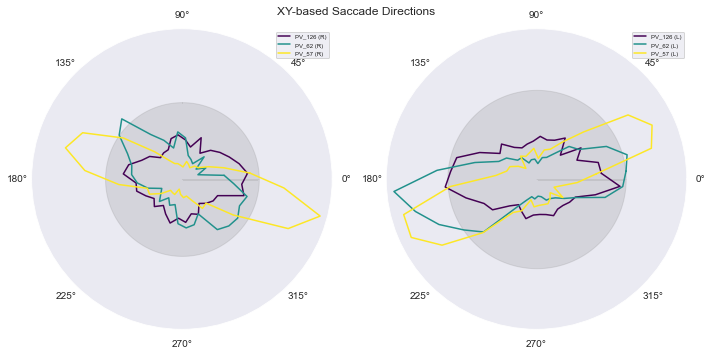

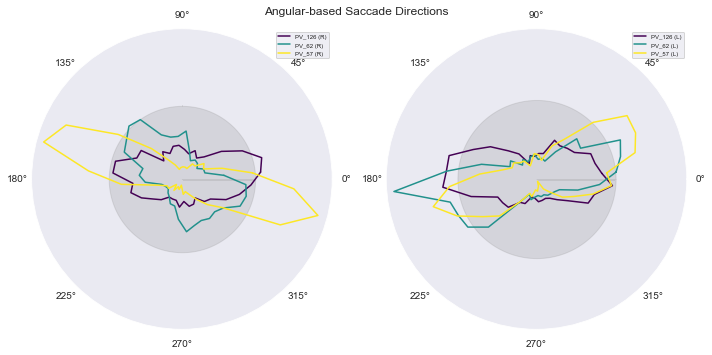

In [5]:
def plot_multi_animal_polar(saccade_collection, title=None):
    animals = saccade_collection['animal'].unique()
    num_bins = 36

    fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=dict(projection='polar'))
    colors = plt.cm.viridis(np.linspace(0, 1, len(animals)))

    for color, animal in zip(colors, animals):
        df_animal = saccade_collection.query('animal == @animal')

        # Right eye
        if 'xy_angle_deg' in df_animal.columns:
            angles_r = df_animal.query('eye == "R"')['xy_angle_deg'].dropna()
        else:
            angles_r = df_animal.query('eye == "R"')['overall_angle_deg'].dropna()
        hist_r, edges_r = np.histogram(angles_r, bins=num_bins, range=(0, 360), density=True)
        centers_r = ((edges_r[:-1] + edges_r[1:]) / 2.0) * (np.pi / 180)
        centers_r = np.concatenate([centers_r, centers_r[:1]])
        hist_r = np.concatenate([hist_r, hist_r[:1]])
        axs[0].plot(centers_r, hist_r, label=f"{animal} (R)", color=color)

        # Left eye
        if 'xy_angle_deg' in df_animal.columns:
            angles_l = df_animal.query('eye == "L"')['xy_angle_deg'].dropna()
        else:
            angles_l = df_animal.query('eye == "L"')['overall_angle_deg'].dropna()
        hist_l, edges_l = np.histogram(angles_l, bins=num_bins, range=(0, 360), density=True)
        centers_l = ((edges_l[:-1] + edges_l[1:]) / 2.0) * (np.pi / 180)
        centers_l = np.concatenate([centers_l, centers_l[:1]])
        hist_l = np.concatenate([hist_l, hist_l[:1]])
        axs[1].plot(centers_l, hist_l, label=f"{animal} (L)", color=color)

    for ax in axs:
        theta = np.linspace(0, 2 * np.pi, 500)
        ax.fill_between(theta, 0, 0.005, color='gray', alpha=0.2)
        ax.set_yticks([])
        ax.grid(False)
        ax.legend(loc='upper right', fontsize=6)
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot XY-based saccade directions
plot_multi_animal_polar(all_xy_saccades, title="XY-based Saccade Directions")

# Plot Angular-based saccade directions
plot_multi_animal_polar(all_angular_saccades, title="Angular-based Saccade Directions")


In [15]:
# Replace this with the actual path to your .pkl file
pkl_path = r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal\2025_01_04_16_02_MultiAnimal_Saccade_Histogram\2025_01_04_16_02_saccade_angles_data.pkl"

# Option 1: Using pandas
all_xy_saccades_old = pd.read_pickle(pkl_path)

In [8]:
for animal in df['animal'].unique():
    for block in df[df['animal'] == animal]['block'].unique():
        print(f"{animal}: {block}")

PV_62: 023
PV_62: 024
PV_62: 026
PV_62: 038
PV_126: 007
PV_126: 008
PV_126: 009
PV_126: 010
PV_126: 011
PV_126: 012
PV_126: 013
PV_57: 007
PV_57: 008
PV_57: 009
PV_57: 010
PV_57: 011
PV_57: 012
PV_57: 013


KeyError: 'overall_angle_deg'

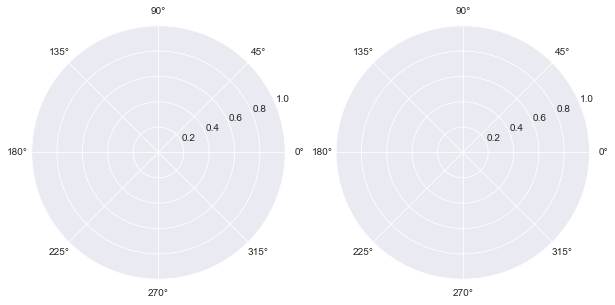

In [16]:

# Plot XY-based saccade directions
plot_multi_animal_polar(all_xy_saccades_old, title="XY-based Saccade Directions")

# Plot Angular-based saccade directions
plot_multi_animal_polar(all_angular_saccades, title="Angular-based Saccade Directions")